In [1]:
import os
import re
import base64
import zipfile
import json
import pickle
from io import BytesIO
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML
sns.set_theme(style="ticks")

In [2]:
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999

In [3]:
plt.rcParams["figure.figsize"] = (20,5)

# Combine Downloaded Data

In the data gathering step, we have created 14 JSON file downloaded from bazaarvoice API. Here we combine all JSON.

In [4]:
#get review details
def get_review_level_df(product_id,file_name):
    review_level_list = ['Id','ProductId','Rating','Title','ReviewText','Helpfulness', 'IsRecommended','SubmissionTime',
                        'ContextDataValues.skinType.ValueLabel','ContextDataValues.eyeColor.ValueLabel','ContextDataValues.hairColor.ValueLabel',
                        'ContextDataValues.skinTone.ValueLabel','ContextDataValues.age.ValueLabel', 'ContextDataDistribution.skinConcerns.ValueLabel']
    df = pd.json_normalize(file_name[product_id][1])
    for i in review_level_list:
        if i not in df:
            df[i] = np.nan
    df_review_level = df.loc[:,review_level_list]
    df_review_level['productID'] = product_id
    df_review_level['skuID'] = df_review_level['ProductId']
    return df_review_level

In [5]:
#get review_product 
def get_review_product_df(product_id,file_name):
    review_product_list = ['AverageOverallRating','FirstSubmissionTime', 'RecommendedCount', 'NotRecommendedCount','RatingDistribution',
                           'ContextDataDistribution.age.Values','ContextDataDistribution.skinType.Values','ContextDataDistribution.skinConcerns.Values',
                           'ContextDataDistribution.skinTone.Values','ContextDataDistribution.eyeColor.Values', 
                           'ContextDataDistribution.hairColor.Values']
    
    df = pd.DataFrame(file_name[product_id][0])  
    df= df.transpose().reset_index()
    df['skuID']=df['Id']
    df['productID'] = product_id
    df_header_list=['productID', 'skuID','Name','Brand','BrandExternalId','CategoryId','TotalReviewCount','ReviewStatistics']
    df_header = df.loc[:,df_header_list].copy()
    
    df = pd.json_normalize(df['ReviewStatistics'])
    for i in review_product_list:
        if i not in df:
            df[i] = np.nan
    df_review_product = df.loc[:,review_product_list]
    
    df_review_product = pd.concat([df_header, df_review_product], axis = 1)
    
    return df_review_product

In [6]:
#extract all product
def extract_all_product(file_name):
    products = list(file_name.keys())
    
    review_product_lst = []
    review_level_lst = []
    
    for product_id in products:
#         print(product_id)
        if file_name[product_id] != [[], []] and file_name[product_id] != [None, None]:
            tmp1 = get_review_product_df(product_id,file_name)
            review_product_lst.append(tmp1)
            tmp2 = get_review_level_df(product_id,file_name)
            review_level_lst.append(tmp2)
    
    df_review_product = pd.concat(review_product_lst)
    df_review_level = pd.concat(review_level_lst)
    return [df_review_product, df_review_level]

In [7]:
product_lst = []
review_lst = []
files = [i+1 for i in range(14)]

# 2024
for file in tqdm(files):
    file_result = None
    with open(f'raw_data/reviews/Copy of scraper_result{file}.json', 'rb') as file:
        file_result = json.load(file)
    
    df_review_product, df_review_level = extract_all_product(file_result)
    product_lst.append(df_review_product)
    review_lst.append(df_review_level)
    del file_result

  0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_4033588/3119228108.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_review_level = pd.concat(review_level_lst)
 93%|█████████▎| 13/14 [03:53<00:21, 21.14s/it]/tmp/ipykernel_4033588/3119228108.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_review_level = pd.concat(review_level_lst)
100%|██████████| 14/14 [04:04<00:00, 17.43s/it]


In [8]:
df_product = pd.concat(product_lst)
df_review = pd.concat(review_lst)

In [9]:
# To reduce memory
del product_lst
del review_lst

In [10]:
len(df_product)

16334

In [11]:
len(df_review)

2712518

# Combine data to get product with all details

In [12]:
with open("raw_data/products/json_dictionary_lipstick_category_product_list.pkl", 'rb') as file:
    df_product_list = pickle.load(file)

In [13]:
assert len(df_product_list)==df_product_list.productId.nunique()

In [14]:
df_product_list.rename(columns={'productId':'productID'}, inplace=True)

In [15]:
with open("raw_data/products/downloaded_product_info_page_2024-09-28-2.pkl", 'rb') as file:
    dict_product_details = pickle.load(file)

In [16]:
df_product_details = pd.json_normalize(dict_product_details, max_level=0)

In [17]:
df_product_details.head(2)

,pd_id,size_and_item,category,price,love_count,reviews_count,swatch_images,sku_color_mapping,soup
0,P451920,Size .15 oz/ 4.6 mL,,$22.00get it for $20.90 (5% off) with Auto-Rep...,203.4K,966,[https://www.sephora.com/productimages/sku/s22...,"{'2297505': 'Jellyfish clear', '2486769': 'Unb...","[html, \n, [[<title>Clean Wet Lip Oil Gloss - ..."
1,P508676,None,,$7.00or 4 payments of $1.75 with or,23.6K,87,[],{},"[html, \n, [[<title>Hot Cocoa Lip Sleeping Mas..."


In [18]:
#get skuID to color_description mapping
df_exploded = df_product_details['sku_color_mapping'].apply(lambda x: list(x.items()))
df_exploded = df_exploded.explode()
df_sku_color_description = pd.DataFrame(df_exploded.tolist(), columns=['skuID', 'color_description'])
df_sku_color_description = df_sku_color_description.dropna()
df_sku_color_description.skuID=df_sku_color_description.skuID.astype(str)

In [19]:
len(df_sku_color_description)

1255

# Select Lipstick Products
only keep the products with reviews

In [20]:
df_product_selected = df_product.query("productID in @df_product_list.productID").copy()

In [21]:
df_product_selected = df_product_selected.sort_values(by='TotalReviewCount', ascending=False)
df_product_selected.drop_duplicates(subset=['skuID'], keep='first', inplace=True)

In [22]:
df_product_selected.shape

(2140, 19)

In [23]:
df_product_selected.skuID.nunique()

2140

In [24]:
df_review_selected = df_review.query("productID in @df_product_list.productID").copy()

In [25]:
df_review_selected.shape

(147298, 16)

# Save File
product with detailed information; product with reviews

In [26]:
df_review_selected.rename(columns = {'Id':'reviewID'}, inplace=True)
df_review_selected.drop(columns=['ProductId'],inplace=True)

In [27]:
#df_product_selected.to_pickle("data/product_sku_info_v2.pkl")

In [28]:
#df_review_selected.to_pickle("data/product_sku_review_v2.pkl")

# Add Images to Data Frame

Assigned lipstick image to SKU 980995 with base64 length: 1232
Assigned lipstick image to SKU 1577006 with base64 length: 1172
Assigned lipstick image to SKU 1143452 with base64 length: 1204
Assigned lipstick image to SKU 2311389 with base64 length: 21988
Assigned cover image to SKU 2311389 with base64 length: 7936
Assigned lipstick image to SKU 683490 with base64 length: 672
Assigned cover image to SKU 683490 with base64 length: 459336
Assigned lipstick image to SKU 1790690 with base64 length: 1924
Assigned lipstick image to SKU 1790641 with base64 length: 1924
Assigned lipstick image to SKU 1790781 with base64 length: 5748
Assigned lipstick image to SKU 2036366 with base64 length: 1912
Assigned lipstick image to SKU 2036390 with base64 length: 1896
Assigned lipstick image to SKU 1790674 with base64 length: 1916
Assigned lipstick image to SKU 1790716 with base64 length: 1928
Assigned lipstick image to SKU 2036408 with base64 length: 1900
Assigned cover image to SKU 2036408 with base64


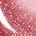

In [29]:
# Paths to your zip files
zip_file_paths = [
    "raw_data/images/product_cover_image.zip",
    "raw_data/images/SKU_lipstick_color_image.zip"
]

# Extract the files from zip
extracted_paths = []

for zip_file in zip_file_paths:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        extract_path = zip_file.replace('.zip', '')
        zip_ref.extractall(extract_path)
        extracted_paths.append(extract_path)

# Function to convert image to base64
def img_to_base64(img_path):
    with open(img_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

# Function to extract SKU ID from filename
def extract_sku_from_filename(filename):
    match = re.search(r's(\d+)[\+\-]', filename)  # Extract SKU ID (digits after 's' and before '+' or '-')
    return match.group(1) if match else None

df_product_selected['cover_image_base64'] = ''
df_product_selected['lipstick_image_base64'] = ''

cover_image_paths = {}
lipstick_image_paths = {}

# Map each image file to SKU ID based on the file type
for path in extracted_paths:
    for root, dirs, files in os.walk(path):
        for file in files:
            sku = extract_sku_from_filename(file)
            if sku:
                img_path = os.path.join(root, file)
                if 'lipstick' in path:
                    lipstick_image_paths[sku] = img_path
                elif 'cover' in path:
                    cover_image_paths[sku] = img_path

# Assign images to DataFrame rows based on skuID
for sku_id in df_product_selected['skuID'].unique():
    # Assign lipstick image if available
    if sku_id in lipstick_image_paths:
        base64_data = img_to_base64(lipstick_image_paths[sku_id])
        df_product_selected.loc[df_product_selected['skuID'] == sku_id, 'lipstick_image_base64'] = base64_data
        print(f"Assigned lipstick image to SKU {sku_id} with base64 length: {len(base64_data)}")
    
    # Assign cover image if available
    if sku_id in cover_image_paths:
        base64_data = img_to_base64(cover_image_paths[sku_id])
        df_product_selected.loc[df_product_selected['skuID'] == sku_id, 'cover_image_base64'] = base64_data
        print(f"Assigned cover image to SKU {sku_id} with base64 length: {len(base64_data)}")

# Debug step: Display a specific SKU as an HTML embedded image for both cover and lipstick images
sku_id_to_check = '980995'

# Display lipstick image
if df_product_selected.loc[df_product_selected['skuID'] == sku_id_to_check, 'lipstick_image_base64'].notna().any():
    lipstick_base64_img_data = df_product_selected.loc[df_product_selected['skuID'] == sku_id_to_check, 'lipstick_image_base64'].values[0]
    lipstick_html_img_tag = f'<img src="data:image/jpeg;base64,{lipstick_base64_img_data}" alt="Lipstick Image for SKU {sku_id_to_check}" />'
    display(HTML("<h3> Lipstick Image </h3>" + lipstick_html_img_tag))

# Display cover image
if df_product_selected.loc[df_product_selected['skuID'] == sku_id_to_check, 'cover_image_base64'].notna().any():
    cover_base64_img_data = df_product_selected.loc[df_product_selected['skuID'] == sku_id_to_check, 'cover_image_base64'].values[0]
    cover_html_img_tag = f'<img src="data:image/jpeg;base64,{cover_base64_img_data}" alt="Cover Image for SKU {sku_id_to_check}" />'
    display(HTML("<h3> Cover Image </h3>" + cover_html_img_tag))


In [30]:
df_product_selected.head(2)

,productID,skuID,Name,Brand,BrandExternalId,CategoryId,TotalReviewCount,ReviewStatistics,AverageOverallRating,FirstSubmissionTime,RecommendedCount,NotRecommendedCount,RatingDistribution,ContextDataDistribution.age.Values,ContextDataDistribution.skinType.Values,ContextDataDistribution.skinConcerns.Values,ContextDataDistribution.skinTone.Values,ContextDataDistribution.eyeColor.Values,ContextDataDistribution.hairColor.Values,cover_image_base64,lipstick_image_base64
5,P174213,1143304,Full-On™ Plumping Lip Polish Gloss Sugar,"{'Id': '5984', 'Name': 'Buxom'}",5984,cat60047,12412,"{'AverageOverallRating': 4.622623267805349, 'N...",4.622623,2008-08-28T14:52:58.000+00:00,1085,121,"[{'RatingValue': 5, 'Count': 9316}, {'RatingVa...","[{'Count': 420, 'Value': '13to17', 'ValueLabel...","[{'Count': 209, 'Value': 'normal', 'ValueLabel...",NaN,"[{'Count': 2357, 'Value': 'fair', 'ValueLabel'...","[{'Count': 2405, 'Value': 'blue', 'ValueLabel'...","[{'Count': 311, 'Value': 'blonde', 'ValueLabel...",,
11,P174213,2383644,Full-On™ Plumping Lip Polish Gloss Dylan,"{'Id': '5984', 'Name': 'Buxom'}",5984,cat60047,12412,"{'ContextDataDistributionOrder': ['age', 'Ince...",4.622623,2008-08-28T14:52:58.000+00:00,1085,121,"[{'RatingValue': 5, 'Count': 9316}, {'RatingVa...","[{'Count': 420, 'Value': '13to17', 'ValueLabel...","[{'Count': 209, 'Value': 'normal', 'ValueLabel...",NaN,"[{'Count': 2357, 'Value': 'fair', 'ValueLabel'...","[{'Count': 2405, 'Value': 'blue', 'ValueLabel'...","[{'Count': 311, 'Value': 'blonde', 'ValueLabel...",,


## check some samples


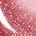

In [31]:
# Retrieve the base64 data for the specific SKU to check the data
sku_id_to_check = '980995'
base64_img_data = df_product_selected.loc[df_product_selected['skuID'] == sku_id_to_check, 'lipstick_image_base64'].values[0]

html_img_tag = f'<img src="data:image/jpeg;base64,{base64_img_data}" alt="Lipstick Image" />'
from IPython.display import HTML
HTML(html_img_tag)

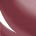

In [32]:
base64_img_data = df_product_selected.loc[df_product_selected['skuID']=='2317253','lipstick_image_base64'].values[0]
img_data = base64.b64decode(base64_img_data)
img = Image.open(BytesIO(img_data))
img


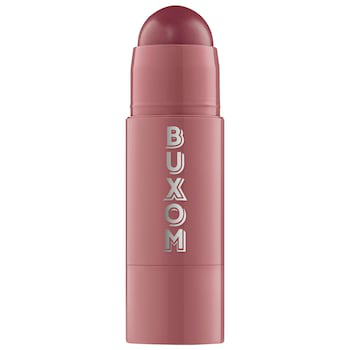

In [33]:
base64_img_data = df_product_selected.loc[df_product_selected['skuID']=='2317253','cover_image_base64'].values[0]
img_data = base64.b64decode(base64_img_data)
img = Image.open(BytesIO(img_data))
img

# Extract RGB from Images

In [34]:
def extract_rgb_from_image_exclude_white_and_transparent(img, white_threshold=240, transparent_threshold=0):
    img = img.convert('RGBA')
    img_array = np.array(img)
    
    # Extract RGB and Alpha channels
    rgb_array = img_array[:, :, :3]
    alpha_array = img_array[:, :, 3]
    
    # Create a mask for non-white pixels and non-transparent pixels
    mask_non_white = np.all(rgb_array < white_threshold, axis=-1)
    mask_non_transparent = alpha_array > transparent_threshold
    combined_mask = mask_non_white & mask_non_transparent
    
    filtered_rgb_array = rgb_array[combined_mask]
    
    if len(filtered_rgb_array) > 0:
        avg_color = filtered_rgb_array.mean(axis=0)
    else:
        avg_color = np.array([0, 0, 0])  
    
    return avg_color.astype(int)  

In [35]:
# Function to handle base64 decoding and RGB extraction, with error handling
def process_base64_image(base64_data):
    try:
        img_data = base64.b64decode(base64_data)
        img = Image.open(BytesIO(img_data))
        # Extract RGB values, excluding white and transparent pixels
        return extract_rgb_from_image_exclude_white_and_transparent(img)
    except:
        return None  # Return None or a default value when the image cannot be processed


In [36]:
# Apply the function to each row in the 'lipstick_image_base64' column
df_product_selected['avg_rgb'] = df_product_selected['lipstick_image_base64'].apply(process_base64_image)

In [37]:
print(f"# Total SKUs: {df_product_selected.shape[0]}")
print(f"# No SKU images: {df_product_selected[df_product_selected['avg_rgb'].isna()].shape[0]}")
print(f"# No SKU images but have cover image: {df_product_selected[df_product_selected['avg_rgb'].isna() & df_product_selected['cover_image_base64'].notna() & (df_product_selected['cover_image_base64'] != '')].shape[0]}")

# Total SKUs: 2140
# No SKU images: 1008
# No SKU images but have cover image: 18


Consider the example of product P174213: in the original dataset, it includes 28 SKUs, with four of these having associated SKU images. However, only three SKUs are currently listed on the website. This discrepancy arises from SKU updates; our original scraped data retains all historical SKUs.
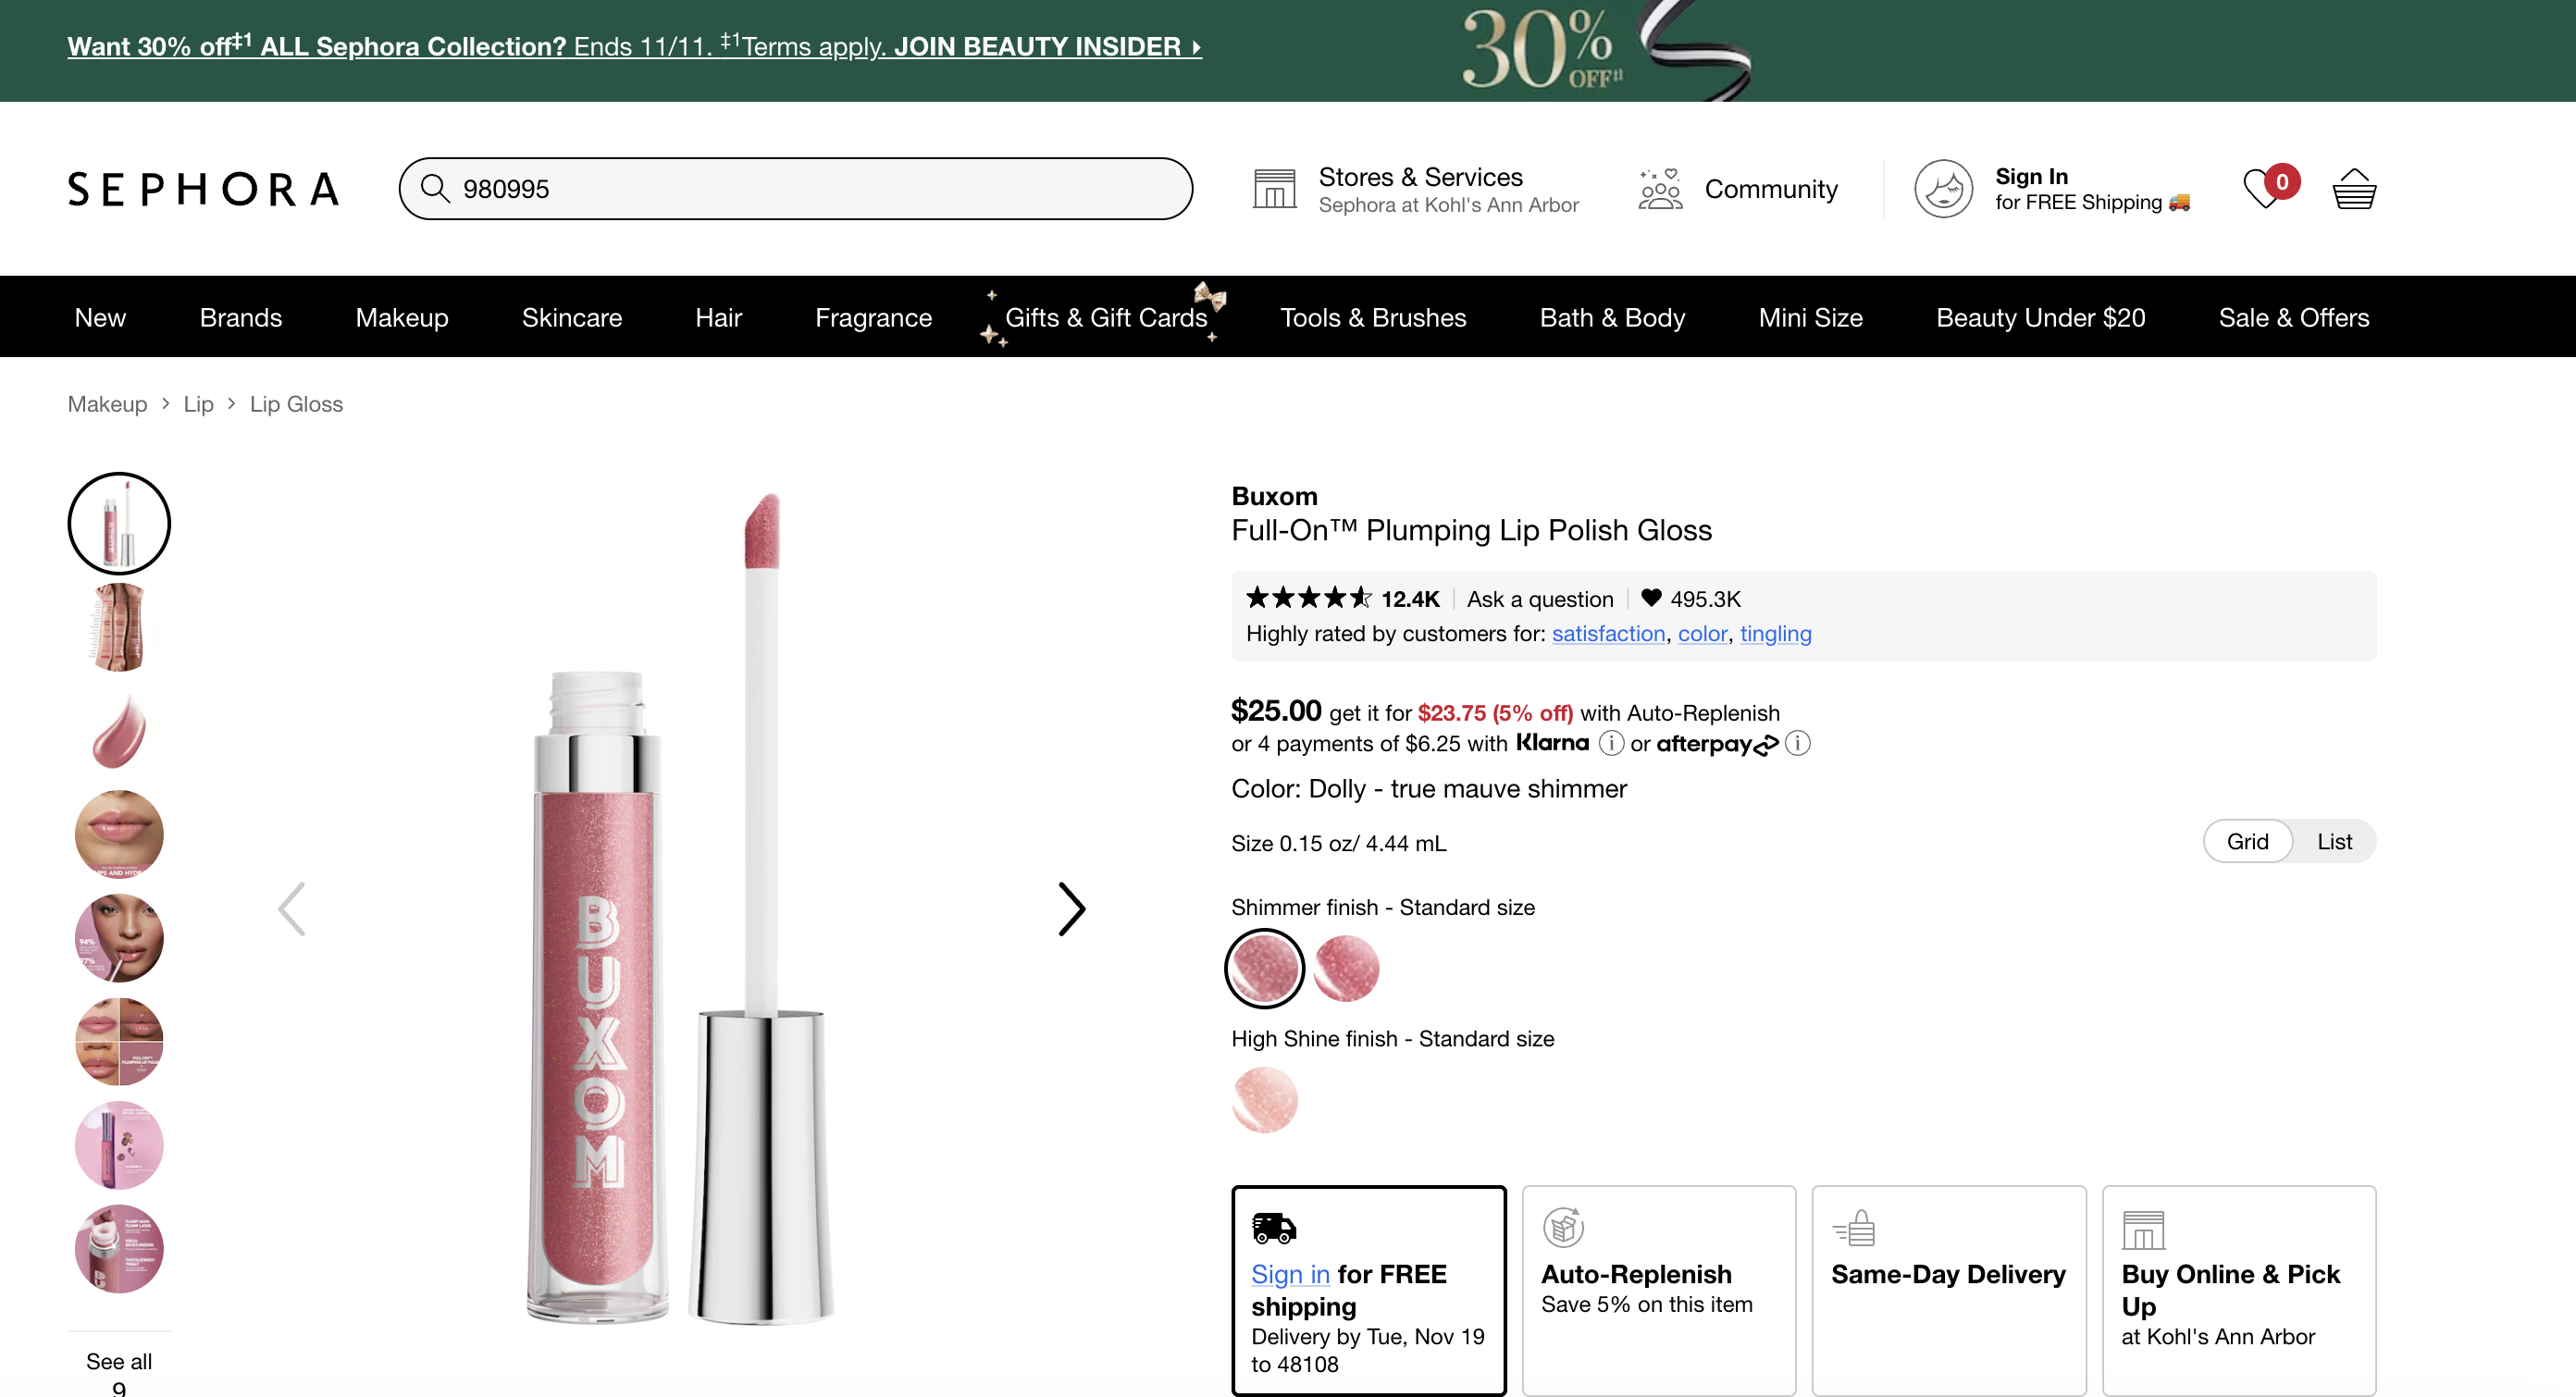

In [38]:
print(f"# Total SKUs for P174213: {df_product_selected[df_product_selected['productID'] == 'P174213'].shape[0]}")
print(f"# P174213 SKUs with lipstick images: {df_product_selected[(df_product_selected['productID'] == 'P174213') & (df_product_selected['lipstick_image_base64'].notna()) & (df_product_selected['lipstick_image_base64'] != '')].shape[0]}")

# Total SKUs for P174213: 28
# P174213 SKUs with lipstick images: 4


## only keep reviews with RGB

In [39]:
# Keep only rows where avg_rgb is not None or NaN
df_product_selected_with_images = df_product_selected[df_product_selected['avg_rgb'].notna()]


# Save Data: product with Images and RGB

In [40]:
#df_product_selected_with_images.to_pickle('data/product_sku_info_with_rgb_v3.pkl')

# Join all
create one table with product info, sku info including sku rgb ,and review info

In [41]:
df_product_review_merge = df_review_selected.merge(df_product_selected_with_images,on=['skuID','productID'], how='inner').merge(df_sku_color_description, on=['skuID'], how='left').merge(df_product_list, on=['productID'], how='left')

In [42]:
df_product_review_merge.shape

(64826, 66)

In [43]:
df_product_review_merge.skuID.nunique()

1132

In [44]:
df_product_review_merge.productID.nunique()

220

# Save File

In [45]:
#df_product_review_merge.to_pickle('data/product_sku_info_with_rgb_review_v3.pkl')